## <font color=blue>Import needed modules</font>

In [1]:
!pip install tensorflow -q     #already available in Google Colab
!pip install -q -U keras-tuner  #will need to install BUT just once on Google Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


In [2]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TensorFlow requirements
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

#scikit learn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,  classification_report
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.dummy import DummyClassifier

#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')

## <font color=blue>Function Definitions

In [3]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [4]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [5]:
#function provided that plots the learning curve for neural networks
# def nn_plot_learning_curve_2( history ):
def nn_plot_learning_curve_2(history):
    # Only keep RMSE and val_RMSE from the history
    # df = pd.DataFrame(history.history)[['RootMeanSquaredError', 'val_RootMeanSquaredError']]

    df = pd.DataFrame(history.history)[['loss', 'val_loss']]
        # Plot RMSE curves
    ax = df.plot(figsize=(8, 5))
    plt.grid(True)

    # Set y-axis to log scale
    # ax.set_yscale('log')

    # Set y-axis limits with margin
    ymin = df.min().min()
    ymax = df.max().max()
    plt.gca().set_ylim(ymin * 0.95, ymax * 1.05)

    plt.xlabel("EPOCHS")
    # plt.ylabel("Root Mean Squared Error")
    # plt.title("Training vs Validation RMSE")
    plt.show()


In [6]:
def nn_plot_learning_curve_3(history):
    # Only keep loss and val_loss from the history, y-axis log scaled
    # df = pd.DataFrame(history.history)[['RootMeanSquaredError', 'val_RootMeanSquaredError']]

    df = pd.DataFrame(history.history)[['loss', 'val_loss']]
        # Plot RMSE curves
    ax = df.plot(figsize=(8, 5))
    plt.grid(True)

    # Set y-axis to log scale
    ax.set_yscale('log')

    # Set y-axis limits with margin
    ymin = df.min().min()
    ymax = df.max().max()
    plt.gca().set_ylim(ymin * 0.95, ymax * 1.05)

    plt.xlabel("EPOCHS")
    # plt.ylabel("Root Mean Squared Error")
    # plt.title("Training vs Validation RMSE")
    plt.show()

In [7]:
def nn_plot_learning_curve_4(history):
    # Only keep RMSE and val_RMSE from the history
    # df = pd.DataFrame(history.history)[['RootMeanSquaredError', 'val_RootMeanSquaredError']]

    df = pd.DataFrame(history.history)
        # Plot RMSE curves
    df = df.iloc[19:]
    ax = df.plot(figsize=(8, 5))
    plt.grid(True)

    # Set y-axis to log scale
    # ax.set_yscale('log')

    # Set y-axis limits with margin
    ymin = df.min().min()
    ymax = df.max().max()
    plt.gca().set_ylim(ymin * 0.95, ymax * 1.05)

    plt.xlabel("EPOCHS")
    # plt.ylabel("Mean Squared Error")
    # plt.title("Training vs Validation RMSE")
    plt.show()

## <font color=blue>Source Data

In [8]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"
filename = "IndegoRides.csv"
downloadDataResource(filename, path)

data = pd.read_csv(filename)

Downloaded IndegoRides.csv


## <font color=blue>Prepare the data set

### Take a look at the data


In [9]:
data.head()

,Date,BikeType,TripType,AvgDuration,NumTrips,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow
0,2021-11-17,Standard,Round Trip,32,55,67,36.93,64.18,0,0,0
1,2019-01-30,Standard,Round Trip,33,22,64,11.79,37.98,0,1,1
2,2019-11-11,Standard,Round Trip,36,67,67,35.91,65.48,0,0,0
3,2022-02-14,Standard,Round Trip,17,23,53,15.30,32.68,0,0,0
4,2020-06-11,Electric,Round Trip,78,74,81,72.91,85.19,0,1,0


In [10]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         9750 non-null   object 
 1   BikeType     9750 non-null   object 
 2   TripType     9750 non-null   object 
 3   AvgDuration  9750 non-null   int64  
 4   NumTrips     9750 non-null   int64  
 5   AvgHumidity  9750 non-null   int64  
 6   MinTemp      9750 non-null   float64
 7   MaxTemp      9750 non-null   float64
 8   Windy        9750 non-null   int64  
 9   Rain         9750 non-null   int64  
 10  Snow         9750 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 838.0+ KB


In [11]:
# looking at missing values
missing_value_sum = data.isnull().sum()
missing_value_sum


,0
Date,0
BikeType,0
TripType,0
AvgDuration,0
NumTrips,0
AvgHumidity,0
MinTemp,0
MaxTemp,0
Windy,0
Rain,0


### Adding additional features

In [12]:
# add a month column (categorical), add year (ordinal), add day of the week (categorical)

# Convert 'date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Extract year, month, and day of the week
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day_of_week'] = data['Date'].dt.dayofweek # Monday=0, Sunday=6


In [13]:
data.head()

,Date,BikeType,TripType,AvgDuration,NumTrips,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow,year,month,day_of_week
0,2021-11-17,Standard,Round Trip,32,55,67,36.93,64.18,0,0,0,2021,11,2
1,2019-01-30,Standard,Round Trip,33,22,64,11.79,37.98,0,1,1,2019,1,2
2,2019-11-11,Standard,Round Trip,36,67,67,35.91,65.48,0,0,0,2019,11,0
3,2022-02-14,Standard,Round Trip,17,23,53,15.30,32.68,0,0,0,2022,2,0
4,2020-06-11,Electric,Round Trip,78,74,81,72.91,85.19,0,1,0,2020,6,3


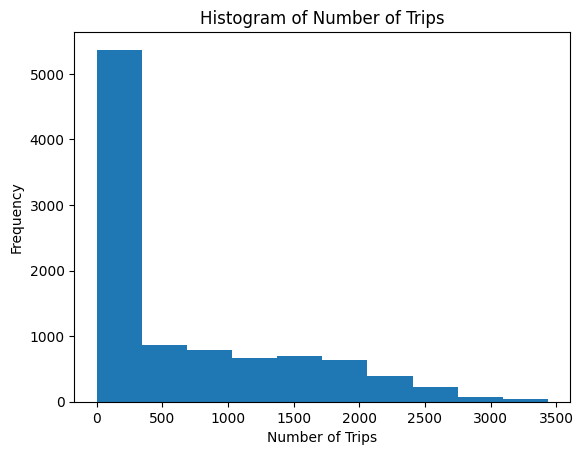

In [14]:
# prompt: Using dataframe data: create a histogram of numtrips

import matplotlib.pyplot as plt
# Create the histogram
plt.hist(data['NumTrips'], bins=10)  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Trips')

# Display the histogram
plt.show()


##NN to forecast the number of trips.

### Split data set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['AvgDuration','NumTrips']),
    data.NumTrips,
    test_size=.2,
    random_state=32
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7800, 12), (7800,), (1950, 12), (1950,))

### Prepare the data

In [16]:
cat_attribs = ['BikeType', 'TripType', 'month', 'day_of_week']
num_attribs_test = list( X_train.drop(columns=cat_attribs,axis=1) )
print(num_attribs_test)

['Date', 'AvgHumidity', 'MinTemp', 'MaxTemp', 'Windy', 'Rain', 'Snow', 'year']


How do we handle date? Assuming ordinal for now

In [17]:
# categorical attributes for this data set
cat_attribs = ['BikeType', 'TripType', 'month', 'day_of_week']

# ordinal attribute (no scaling, but median imputation)
ord_attribs = ['year']

# scaled numerical attributes (for neural networks)
num_attribs = [ 'AvgHumidity', 'MinTemp',
               'MaxTemp', 'Windy', 'Rain', 'Snow']

# define pipeline for scaled numeric attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', MinMaxScaler()),
])

# define pipeline for ordinal numeric attributes (no scaling)
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median"))
])

# define the pipeline process for the dataset
col_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('ord', ord_pipeline, ord_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

full_pipeline = Pipeline([
    ('col_pipeline', col_pipeline),
])


In [18]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((7800, 30), (1950, 30))

### Prepare the data

In [19]:
#scale the Y data
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_actual = y_test
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

### Create a Baseline Prediction

In [20]:
#predcition is based on last observed value
baseline_prediction = yscaler.inverse_transform( y_train.mean().reshape(-1,1))
predictions = np.full(shape=y_test.shape[0], fill_value = baseline_prediction)
print(predictions.shape)

#calculate the root mean square error between the prediction and the actual
print(f"Baseline guess for any day: {predictions[0]}")
naive = root_mean_squared_error(y_test,predictions)
print( f'Naive ERROR: {naive:,.0f} (NumTrips)' )

(1950,)
Baseline guess for any day: 666.3889743589745
Naive ERROR: 666 (NumTrips)


Is that correct? Seems to high

### Build the Neural Network, Compile & Train

In [21]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

In [22]:
#the same steps above can be built and saved in a single command with the same results
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

In [23]:
#After model is created, it needs to be compiled - this requires setting
#the loss function to mean_squared_error
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["RootMeanSquaredError"]
             )

In [24]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data is dynamically allocated at 20% of the training data
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=10)
history = model.fit(X_train,
                    y_train,
                    batch_size = 32,
                    epochs=500,
                    shuffle=True,
                    validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - RootMeanSquaredError: 223.6478 - loss: 50034.8906 - val_RootMeanSquaredError: 202.8728 - val_loss: 41157.3711
Epoch 2/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - RootMeanSquaredError: 196.3604 - loss: 38571.4023 - val_RootMeanSquaredError: 177.1836 - val_loss: 31394.0430
Epoch 3/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - RootMeanSquaredError: 171.1862 - loss: 29316.5957 - val_RootMeanSquaredError: 153.5241 - val_loss: 23569.6504
Epoch 4/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - RootMeanSquaredError: 148.0098 - loss: 21916.9277 - val_RootMeanSquaredError: 131.7751 - val_loss: 17364.6895
Epoch 5/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - RootMeanSquaredError: 126.7247 - loss: 16067.5537 - val_RootMeanSquaredError: 111.8636 - val_loss: 12513.4551
Epoch 6/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - RootMeanSquaredError: 107.2580 - loss: 11511.2637 - val_RootMeanSquaredError: 93.7242 - val_loss: 8784.2266
Epoch 7/50

### Evaluate Performance

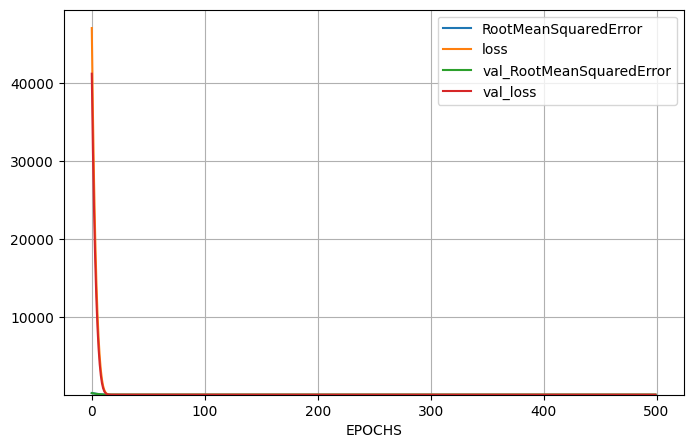

In [25]:
nn_plot_learning_curve(history)

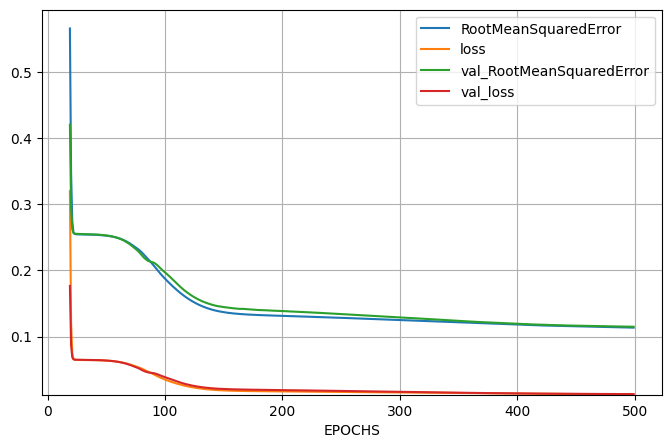

In [26]:
nn_plot_learning_curve_4(history)

Since the value of the loss function in the first epoch was large, the behavior of the learning curve as we get to smaller epochs was not reflected and scaled well in the provided function. this graph looks at epoch 19 and onwards when the loss value is smaller than 1.

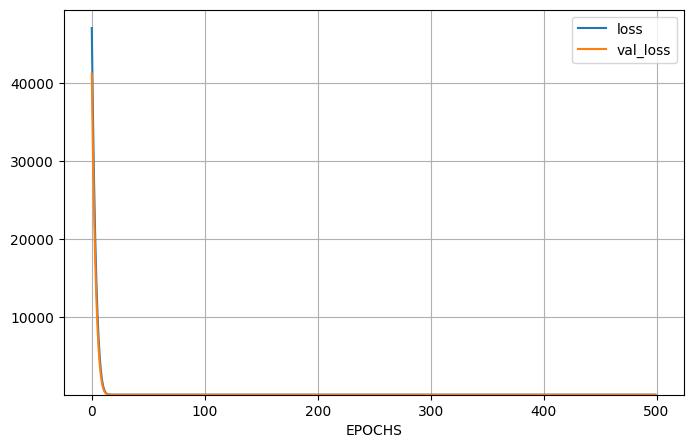

In [27]:
nn_plot_learning_curve_2(history)

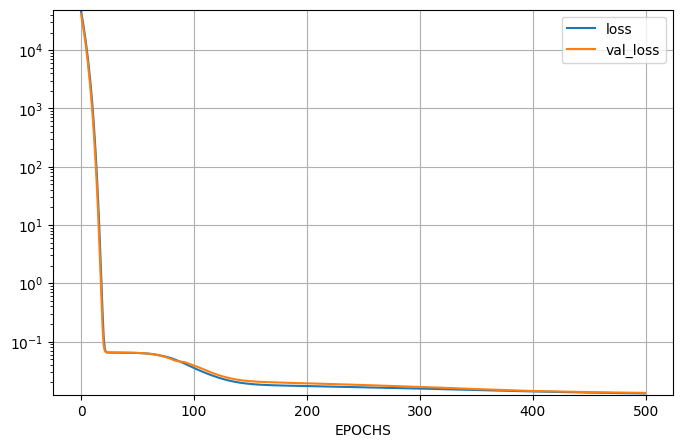

In [28]:
nn_plot_learning_curve_3(history)

logarithmic scale of loss and val loss

In [29]:
#evaluate model loss metric on the training set
mse, rmse = model.evaluate(X_train, y_train, verbose =0)

print( f"Training RMSE: {rmse:,.4f}, Training MSE: {mse:,.4f}" )

Training RMSE: 0.1129, Training MSE: 0.0128


In [30]:
#evaluate model loss metric on the Test set
mse, rmse = model.evaluate(X_test, y_test, verbose=0)
print( f"Test RMSE: {rmse:,.4f}, Test MSE: {mse:,.4f}" )

Test RMSE: 0.1114, Test MSE: 0.0124


In [31]:
#predict the Training data set based on SCALED values
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(actual, pred)
print(f'RMSE: {rmse:,.2f} (NumTrips)' )

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 387.95 (NumTrips)


In [32]:
#predict the test data set based on SCALED values
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(actual, pred)
print(f'RMSE: {rmse:,.2f}(NumTrips)')

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 382.67(NumTrips)


In [33]:
#print the first 5 test cases
for x in range(5):
    print( f"Actual {actual[x].item():10,.2f} --- Prediction {pred[x].item():10,.2f}" )

Actual      12.00 --- Prediction      99.40
Actual      46.00 --- Prediction      75.97
Actual      23.00 --- Prediction       5.37
Actual   1,944.00 --- Prediction   1,609.71
Actual     410.00 --- Prediction     649.01


## <font color=Blue>Hyperparameter Tuning - Regression Model

In [34]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

### Define Regression Model & Design Options (layers & hyperparameters)

In [35]:
def reg_model_builder(hp):

    #select an optimizer and learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.0001, 0.00001])#values=[.01,.001,.0001])
    optimizer = hp.Choice("optimizer", values=["adam","sgd"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #choose the number of neurons (i.e. the number of units)
    hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
    # print("Units:", hp_units)
    #choose the number of layers
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=2)

    #build the model
    model = keras.Sequential()

    #first layer
    model.add(keras.layers.Flatten())

    #hidden layers
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    #last layer
    model.add(keras.layers.Dense(1))

    #compile the model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["RootMeanSquaredError"])

    return model

### Create a Hyperband Tuning Object

In [36]:
tuner = kt.Hyperband(reg_model_builder,
                     objective='val_loss',
                     max_epochs=200,                                    #increase for more trials (but will take longer)
                     overwrite=True,                                 #change to False and model will continue to learn from previous runs
                     hyperband_iterations=5,
                     seed=42,
                     project_name="Indego"                          #a local directory with this name will be created (houses log files)
                     )


In [37]:
# Search for the best performing models

early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=10)
tuner.search(X_train, y_train,
             epochs=500,
             validation_split=0.2,
             shuffle=True,
             callbacks=[early_stopping]
             )

Trial 164 Complete [00h 00m 24s]
val_loss: 0.04884526506066322

Best val_loss So Far: 0.017743876203894615
Total elapsed time: 00h 18m 59s


In [38]:
8# Get the optimal hyperparameters

best_params=tuner.get_best_hyperparameters(num_trials=1)[0]
best_params.values

{'learning_rate': 0.0005,
 'optimizer': 'adam',
 'units': 10,
 'n_hidden': 5,
 'tuner/epochs': 23,
 'tuner/initial_epoch': 8,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0150'}

In [39]:
#build the best model based on these parameters
best_model = reg_model_builder(best_params)


In [40]:
#fit the data to the best model & its parameters
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=10)
history=best_model.fit(X_train, y_train,
             epochs=500,
             validation_split=0.2,
             callbacks=[early_stopping]
             )

Epoch 1/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 19.9141 - loss: 515.9319 - val_RootMeanSquaredError: 0.2248 - val_loss: 0.0505
Epoch 2/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2239 - loss: 0.0502 - val_RootMeanSquaredError: 0.2241 - val_loss: 0.0502
Epoch 3/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2236 - loss: 0.0500 - val_RootMeanSquaredError: 0.2235 - val_loss: 0.0499
Epoch 4/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2231 - loss: 0.0498 - val_RootMeanSquaredError: 0.2229 - val_loss: 0.0497
Epoch 5/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2224 - loss: 0.0495 - val_RootMeanSquaredError: 0.2220 - val_loss: 0.0493
Epoch 6/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2215 - loss: 0.0491 - val_RootMeanSquaredError: 0.2204 - val_loss: 0.0486
Epoch 7/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.

In [41]:
#review the model
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (32, 30)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 10)               │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 10)               │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 10)               │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 10)               │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 10)               │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 1)                │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,285 (8.93 KB)

 Trainable params: 761 (2.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,524 (5.96 KB)

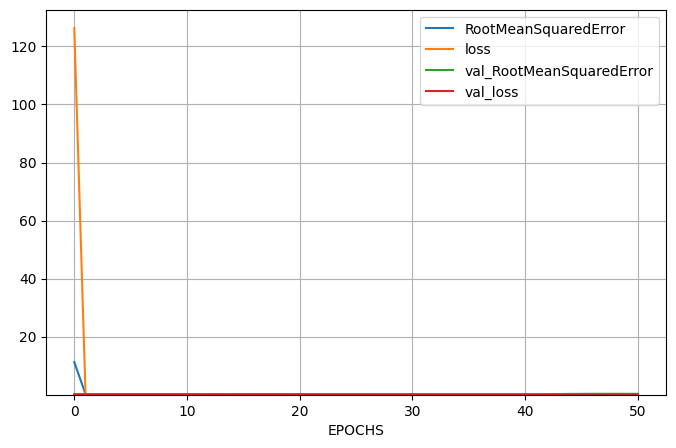

In [42]:
#plot the model's learning curve
nn_plot_learning_curve(history)

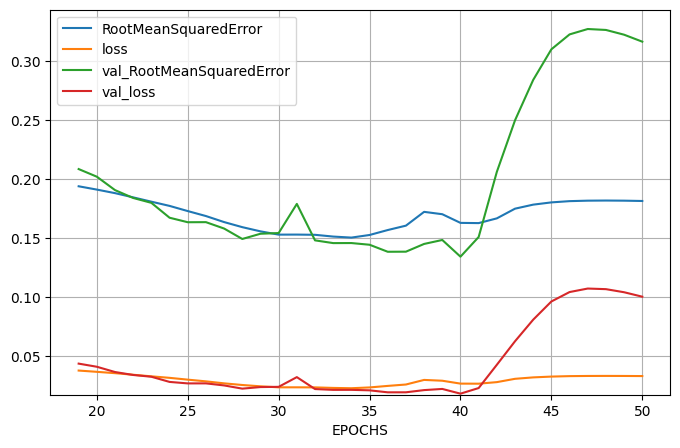

In [43]:
nn_plot_learning_curve_4(history)

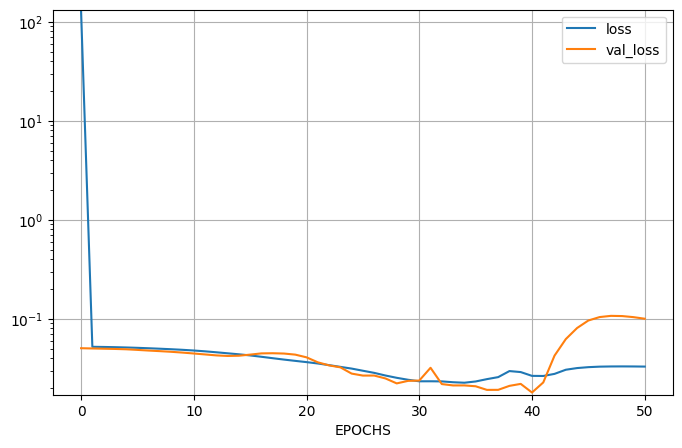

In [44]:
nn_plot_learning_curve_3(history)

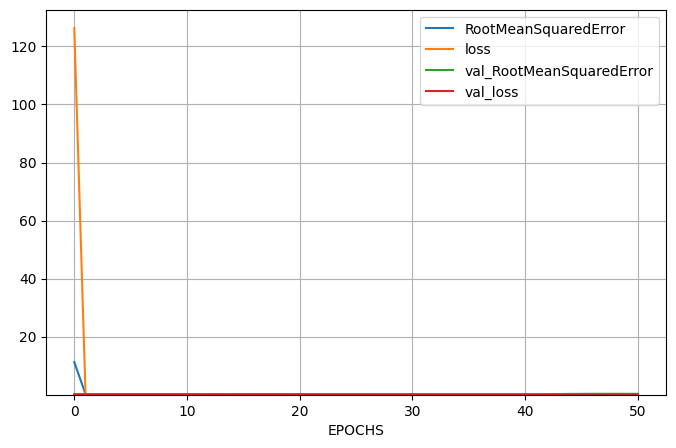

In [45]:
nn_plot_learning_curve(history)

### Evaluate the Optimal Model

In [46]:
#evaluate Training Data
mse, rmse = best_model.evaluate(X_train, y_train)
print( f"Training RMSE: {rmse:,.4f}" )

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.3152 - loss: 0.0994
Training RMSE: 0.3182


In [47]:
#evaluate Test Data
mse, rmse = best_model.evaluate(X_test, y_test)
print( f"Test RMSE: {rmse:,.4f}" )

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.3222 - loss: 0.1038
Test RMSE: 0.3225


In [48]:
#predict the Training data set based on SCALED values
y_pred = best_model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(actual, pred)
print(f'Training RMSE: {rmse:,.2f}' )

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training RMSE: 1,093.12


In [49]:
#predict the test data set based on SCALED values
y_pred = best_model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(pred,actual)
print(f'Test RMSE: {rmse:,.2f}' )

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test RMSE: 1,107.84


In [50]:
#print using format
for x in range(5):
    print( f"Actual {actual[x].item():10,.0f} --- Prediction {pred[x].item():10,.0f}" )

Actual         12 --- Prediction     -1,073
Actual         46 --- Prediction       -996
Actual         23 --- Prediction     -1,397
Actual      1,944 --- Prediction        379
Actual        410 --- Prediction       -242


### Predict a number of trips

In [51]:
# retrive the IndegoRidesToPredict.csv file and create pred_data
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"
filename = "IndegoRidesToPredict.csv"
downloadDataResource(filename, path)
pred_data = pd.read_csv(filename)
pred_data.head()

Downloaded IndegoRidesToPredict.csv


,Date,BikeType,TripType,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow
0,2020-02-01,Standard,One Way,89,35.10,46.29,0,1,0
1,2020-07-20,Standard,One Way,65,78.06,97.99,0,0,0
2,2022-02-12,Standard,Round Trip,44,44.91,60.69,0,0,0
3,2020-06-08,Standard,One Way,42,55.98,82.69,0,0,0
4,2019-08-26,Electric,One Way,70,58.28,76.48,0,0,0


In [52]:
# Repeating the same feauture enginerring
pred_data['Date'] = pd.to_datetime(pred_data['Date'])

pred_data['year'] = pred_data['Date'].dt.year
pred_data['month'] = pred_data['Date'].dt.month
pred_data['day_of_week'] = pred_data['Date'].dt.dayofweek

#X_pred_raw = pred_data.copy()  # copy just in clase

X_example = full_pipeline.transform(pred_data)  # Shape: (5, num_features)
print(pred_data.shape)
print(X_example.shape)

(5, 12)
(5, 30)


In [53]:
#predict the test data set based on SCALED values
y_pred = best_model.predict(X_example)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )

print(f'Prediction: {pred[0][0]:,.2f}' )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: 6.61


In [54]:
for i in range(len(pred)):
    date_str = pred_data.loc[i, 'Date'].strftime('%Y-%m-%d')
    print(f"Prediction for {date_str}: {int(round(pred[i][0]))} trips")

Prediction for 2020-02-01: 7 trips
Prediction for 2020-07-20: 680 trips
Prediction for 2022-02-12: -1082 trips
Prediction for 2020-06-08: 541 trips
Prediction for 2019-08-26: 380 trips


In [55]:
#predict the test data set based on SCALED values
y_pred_og = model.predict(X_example)

#scale predicted and actuals
pred_og = yscaler.inverse_transform( y_pred_og )

print(f'Prediction: {pred_og[0][0]:,.2f}' )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: 852.38


In [56]:
for i in range(len(pred_og)):
    date_str = pred_data.loc[i, 'Date'].strftime('%Y-%m-%d')
    print(f"Prediction for {date_str}: {int(round(pred_og[i][0]))} trips")

Prediction for 2020-02-01: 852 trips
Prediction for 2020-07-20: 2090 trips
Prediction for 2022-02-12: 137 trips
Prediction for 2020-06-08: 1818 trips
Prediction for 2019-08-26: 1325 trips


## New Experiment with keras tuner.

In [57]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

In [58]:
def reg_model_builder(hp):

    #select an optimizer and learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0005, 0.0001, 0.00001])#values=[.01,.001,.0001])
    optimizer = hp.Choice("optimizer", values=["adam","sgd"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #choose the number of neurons (i.e. the number of units)
    hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
    # print("Units:", hp_units)
    #choose the number of layers
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=2)

    #build the model
    model = keras.Sequential()

    #first layer
    model.add(keras.layers.Flatten())

    #hidden layers
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    #last layer
    model.add(keras.layers.Dense(1, activation='relu'))

    #compile the model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["RootMeanSquaredError"])

    return model

In [59]:
tuner = kt.Hyperband(reg_model_builder,
                     objective='val_loss',
                     max_epochs=200,                                    #increase for more trials (but will take longer)
                     overwrite=True,                                 #change to False and model will continue to learn from previous runs
                     hyperband_iterations=5,
                     seed=42,
                     project_name="Indego"                          #a local directory with this name will be created (houses log files)
                     )


In [ ]:
# Search for the best performing models

early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=10)
tuner.search(X_train, y_train,
             epochs=500,
             validation_split=0.2,
             shuffle=True,
             callbacks=[early_stopping]
             )

Trial 218 Complete [00h 00m 26s]
val_loss: 0.05778077617287636

Best val_loss So Far: 0.0132966423407197
Total elapsed time: 00h 39m 16s


In [ ]:
8# Get the optimal hyperparameters

best_params_2=tuner.get_best_hyperparameters(num_trials=1)[0]
best_params_2.values

{'learning_rate': 1e-05,
 'optimizer': 'adam',
 'units': 30,
 'n_hidden': 3,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 4,
 'tuner/round': 4,
 'tuner/trial_id': '0142'}

In [ ]:
#build the best model based on these parameters
best_model_withRelu = reg_model_builder(best_params_2)
# best_model_withRelu = tuner.hypermodel.build(best_params_2)

In [ ]:
#fit the data to the best model & its parameters
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=20)
history_best_model_withRelu=best_model_withRelu.fit(X_train, y_train,
             epochs=500,
             validation_split=0.2,
             callbacks=[early_stopping]
             )

Epoch 1/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 2/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 3/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 4/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 5/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 6/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.2955 - loss: 0.0874 - val_RootMeanSquaredError: 0.2985 - val_loss: 0.0891
Epoch 7/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.295

In [ ]:
best_model_withRelu.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (32, 30)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 30)               │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 30)               │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 30)               │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 1)                │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,465 (33.07 KB)

 Trainable params: 2,821 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,644 (22.05 KB)

In [ ]:
#evaluate Test Data
mse, rmse = best_model_withRelu.evaluate(X_test, y_test)
print( f"Test RMSE: {rmse:,.4f}" )

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.2997 - loss: 0.0899
Test RMSE: 0.2985


In [ ]:
#evaluate Test Data
mse, rmse = best_model_withRelu.evaluate(X_train, y_train)
print( f"Train RMSE: {rmse:,.4f}" )

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.2956 - loss: 0.0875
Train RMSE: 0.2997


In [ ]:
#predict the Training data set based on SCALED values
y_pred = best_model_withRelu.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(actual, pred)
print(f'Training RMSE: {rmse:,.2f}' )

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Training RMSE: 1,029.32


In [ ]:
#predict the test data set based on SCALED values
y_pred = best_model_withRelu.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = root_mean_squared_error(actual, pred)
print(f'RMSE: {rmse:,.2f}(NumTrips)')

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 1,025.42(NumTrips)
